# 순환 신경망 RNN

# Sequential Data란?
**Sequential Data**는 데이터와 데이터가 나타난 위치가 중요한 데이터를 말한다.

우리가 흔히 알고있는 대부분의 데이터들을 Squential Data라고 부르는데, 예로 Speech, Text, Image 데이터들이 Sequential Data라 할 수 있다.

우리가 주식데이터를 가지고 있다고 생각해보자.
> 
데이터 1: 2000 2050 2100 2150 (상승)
데이터 2: 2150 2100 2050 2000 (하락) 

여기서 데이터 1과 2에 있는 2100이라는 숫자가 같은 의미를 가지고 있을까? 

상승하는 2100과 하락하는 2100은 의미가 다를 것이다. 다시말하면 2100이 "있다/없다"가 중요한 것이 아니라 
2100의 위치는 어디에 있는지, 2100의 앞/뒤에는 어떤 숫자가 있는지가 중요한 것이다.

하나 더 예를 들어서 이미지를 보자.

![](https://images.velog.io/images/a01152a/post/e1ef5485-7f90-450c-860c-35a1208ef18b/image.png)
고양이 그림이 픽셀 단위로 Suffle 되면 우리는 저 그림을 고양이라고 하지 않을 것이다. 
**Suquential Data는 어떤 데이터가 있는가 없는가도 중요하지만 어떠한 순서로 되어있는가도 매우 중요하다.**


# RNN

RNN의 '순환'에는 어떤 의미가 있을까? 물론 '반복해서 되돌아감'을 의미한다. RNN을 살펴보자.
![](https://images.velog.io/images/a01152a/post/b911ea8f-5c7f-4d41-9e70-51b6a6d46901/image.png)
흔한 Fully Connected Layer이다. 입력벡터로 들어가서 layer를 지나 출력 벡터를 꺼내는 방식이다. 

여기에 C1,C2,Ck Layer를 추가해보자.
![](https://images.velog.io/images/a01152a/post/7b852566-4b7b-4aa6-b0bc-44846c3329a3/image.png)
C1, C2 ... Ck 레이어는 matmul, activation등등 processing을 진행하는 노드들과는 다르게 단지 버퍼, 메모리 어떤 값을 저장하는 용도로 쓰인다. 

h1, h2 ... hk 의 값을 c1, c2에 저장한다.

#### 간단하게 동작 순서를 설명하면,
- 입력 벡터 원소, 하나의 입력이 들어가면 이에 대응하여 hidden layer의 결과(h1, h2 ... hk)가 일어난다.

- h는 output을 위해 다음 계층으로 전달된다.
<span style="color:red"> h을 copy하여 c1, c2 ... ck에 저장한다. (h1)</span>

- 2번째 입력 벡터 원소를 입력하면, x1, x2 ... xm만 들어가는 것이 아니라, 
<span style="color:blue"> 전에 저장해 놓았던 c1, c2 ... ck 값이 hidden layer에 들어간다.</span>

- h는 output을 위해 다음 계층으로 전달된다.
<span style="color:red"> h을 copy하여 c1, c2 ... ck에 저장한다. (h2)</span>

**... 반복**

> C의 초기값은 0으로 해도 되고, 랜덤값으로 주어도 된다. 
참고로 첫번째 입력 벡터 원소에 입력할 때에도 사실 C값(초깃값)이 사용된다.

이를 쉽게 블럭으로 바꾸면
![](https://images.velog.io/images/a01152a/post/2187c607-28a8-418d-a36d-c753da8e97ce/image.png)
이렇게 표현할 수 있다. 이렇게 보니 단순 Neural Network인게 보인다.

문장을 단어로 바꾸어서 생각해보았을 때, 
train 데이터는 (x0, h0), (x1, h1), (x2, h2) ... (xt, ht) 이를 시계열 데이터로 사용할 수 있다. 
![](https://images.velog.io/images/a01152a/post/7a66efb3-4cbe-4543-bb3b-3862373fe632/image.png)

RNN 계층의 순환 구조를 펼침으로써 오른쪽으로 긴 신경망으로 변신 시킬 수 있다. 
그림에서 등장하는 RNN들 모두가 실제로는 '같은 계층'인 것이 지금까지 신경망과는 다르다.

RNN의 수식은 다음과 같다.
![](https://images.velog.io/images/a01152a/post/f72e41f0-36a5-4856-b1f5-bf21270380a0/image.png)

- h는 hidden state vector이라고 표현한다. (은닉 상태 벡터)
- 행렬곱을 계산하면 그 합을 tanh함수를 이용해 변환한다.


## BPTT

**BPTT**는 '시간 방향으로 펼친 신경망의 오차역전파법' (Backpropagation Through Time)을 의미한다.
![](https://images.velog.io/images/a01152a/post/31e2c5cb-b1c4-4d8a-891a-6d9ade2c28b7/image.png)
이전 모델과 같이 순전파를 수행하고, 이어서 역전파를 수행하여 원하는 기울기를 구할 수 있다. 
여기서 사용하는 오차역전파 법이 BPTT이다. 하지만 긴 시계열 데이터 학습할 때 문제가 생긴다. 

바로 **역전파 과정에서 상당한 컴퓨팅 메모리를 사용한다는 것과, 너무 Sensitive한 gradient를 얻는 다는 것이다.**

## BPTT 문제점

RNN은 Long Term Dependency를 잘 모델링 하지 못한다.
![](https://images.velog.io/images/a01152a/post/1433997b-66ea-4d78-80a1-8cc430607c15/%EB%85%B8%ED%8A%B8_20210728_010947_03.jpg)

만약에 O5를 구하려고 W의 값을 조정하면 너무 sensitive해서 exponential decay로 W이 0이 되어 소멸하거나, 
exponential growth로 기하급수적으로 증가할 것이다.

## Truncated BPTT

그래서 해결 방법이 신경망 연결을 적당한 길이로 '끊는 것'인데, '역전파'의 연결만 끊어 블록단위로 학습을 하는 것이 포인트이다.

만약 1,000개의 시계열 데이터가 있다고 한다면, RNN 계층이 1,000개나 늘어선 신경망이 된다. 
![](https://images.velog.io/images/a01152a/post/e804df21-4df4-4bb2-baf2-dc89ceb3c3a4/image.png)
기존 BPTT로 하면 당연히 방금 언급한 것과 같은 문제가 생긴다.

![](https://images.velog.io/images/a01152a/post/3376f7ef-235f-4bb5-88f9-294871370916/image.png)

그래서 역전파의 연결을 단위로 끊어서 학습하게된다. 이러면 단위보다 미래의 데이터에 대해서는 생각할 필요가 없어진다. 

즉 **블록**으로 만들어, 독립적으로 오차역전파법을 시킨다.
>
중요한점은 **순전파 연결은 끊지 않는다는 것**이다. 이는 데이터를 순서대로 입력한다는 것을 말한다.

![](https://images.velog.io/images/a01152a/post/871a0450-9eed-46ce-ab92-5b8dc4b80c62/image.png)

가중치 갱신은 첫 번째 블록이 블록 내부에서 순전파를 실행하고 

역전파 과정을 거쳐서 기울기를 바탕으로 갱신 된 가중치 조건들이

두 번째 블록의 가중치 초기 조건으로 사용된다.

마찬가지로 두 번째 블록의 계층들이 해당 초기 가중치 조건으로 순전파를 진행한 후

다시 끝에서 처음까지(블록 안 기준) 역전파를 해서 갱신된 가중치 조건들이 

세 번째 블록의 가중치 초기 조건으로 사용된다.

이런식으로 반복이되고 이를 통해 <span style="color:red">**기존 블록의 갱신된 가중치가 다음 블록으로 넘어가서 실행되고 갱신되므로 역전파를 끊어서 사용해도 학습에 크게 지장이 없다**</span>는 것을 알 수 있다.

## 미니배치 학습

지금까지의 설명은 미니배치 수가 1일 때를 설명했다.
미니배치 학습이 좋은 측면이 있어서, 미니 배치를 하기위해 데이터를 주는 시작 위치를 각 미니 배치의 시작 위치로 '옮겨줘야'한다. 

> 
'옮긴다'라는 뜻을 길이가 1000인 시계열 데이터에 대해서 시각의 길이를 10개 단위로 잘라 Truncated BPTT로 학습하는 경우를 예로한다.

![](https://images.velog.io/images/a01152a/post/d7123724-1ee0-4bb7-b401-ff4a36993f9a/image.png)

미니배치 수를 2개로 구성한다고 하면,

첫 번째 미니 배치 때는 0번부터 순서대로 499번 까지 10개씩 묶을 것이다.(50 묶음)

두 번째 미니 배치 때는 500번째 데이터를 시작으로 999번까지 10개씩 묶어 (50 묶음) 배치의 수가 2개인 데이터를 만든다.

그리고 미니 배치별로 데이터를 제공하는 시작위치를 옮겨준다.

이처럼 미니배치 학습을 수행할 때는 
1. **각 미니배치의 시작 위치를 오프셋으로 옮겨**준 후 **순서대로** 제공하면 된다.
2. 데이터를 순서대로 입력하다 끝에 도달하면 다시 처음부터 입력하도록 한다.

# RNN 구현

![](https://images.velog.io/images/a01152a/post/44767b5d-1419-4e44-8460-b016c1d6048b/image.png)
Time RNN 계층 : 순환 구조를 펼친 후의 계층들을 하나의 계층으로 간주한다.

우리가 구현 할 신경망은 가로 방향으로 펼친 신경망이다.

Time RNN 계층 내에서 한 단계의 작업을 수행하는 계층을 'RNN 계층'이라고 하고, T개 단계분의 작업을 한꺼번에 처리하는 계층을 'Time RNN 계층'이라고 한다.
> 시계열 데이터를 한꺼번에 처리하는 계층 앞에 'Time'을 붙이겠다. ex. Time Affine, Time Embedding

![](https://images.velog.io/images/a01152a/post/13e3795a-4c96-45bf-a3ad-04a123b808c4/image.png)

RNN의 순전파 식이다. (이전글에서 설명 함!)
여기에서 데이터를 미니배치로 모아서 처리한다.
```xt```와 ```ht```에 각 샘플 데이터를 행 방향(N)에 저장한다.

![](https://images.velog.io/images/a01152a/post/d88c602b-d8cb-47b8-94c5-2c43ebfdeff0/image.png)
- ```N``` : 미니배치 크기
- ```D``` : 입력 벡터의 차원수
- ```H``` : 은닉 상태 벡터의 차원수

In [2]:
import numpy as np

In [3]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cacahe = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dwx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = dWb
        
        return dx, dh_prev

**```__init__```**
 - ```params``` 변수에 2개의 가중치와 1개의 편향을 저장
 - ```grads``` 변수에 각 매개변수에 대응하는 형태로 기울기를 초기화 한 후 저장한다.
 - ```cache```는 역전파 계산 시 사용하는 중간 데이터를 담아야 하기 때문에 만든다.


 **```forward```**
 - 입력 x와 이전의 h_prev 값을 받아온다.
 - 식 그대로 순전파를 구현한다.
 - cache에 저장
 
 역전파는 어떻게 될까?
![](https://images.velog.io/images/a01152a/post/03033142-18fa-48c5-9871-a5284c5a8024/image.png)
그림처럼 손실함수 J에 대한 미분은 연쇄법칙을 사용하여 RNN으로 역전파 된다.

**```backward```**
![](https://images.velog.io/images/a01152a/post/0803427e-4df4-48f0-9c19-3fa4b87b6c27/image.png)
그림에서 나오는 식을 그대로 위의 코드로 넣었다.
tanh를 미분하면 1-tanh**2의 값이 나오는 것을 참고해서 직접 미분해보면 쉽게 알 수 있다.


# Time RNN 구현

![](https://images.velog.io/images/a01152a/post/acc526d7-92a4-4d85-b966-880feef48884/image.png)

Time RNN 구조를 배웠으니, Time RNN 계층은 은닉 상태를 인스턴스 변수 h로 보관하는 것을 눈치 챌 수 있다.

그러면 은닉 상태를 다음 블록에 인계할 수 있다.

RNN 계층의 은닉 상태를 Time RNN 계층에서 관리한다.
- 이렇게 하면 Time RNN 사용자는 RNN 계층 사이에서 은닉 상태를 '인계하는 작업'을 생각하지 않아도 된다는 장점이 있다.

In [4]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        def __init__(self, Wx, Wh, b, stateful=False):
            self.params = [Wx, Wh, b]
            self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
            self.layers = None
            
            self.h, self.dh = None, None
            self.stateful = stateful
            
        def set_state(self, h):
            self.h = h
        
        def reset_state(self):
            self.h = None
            
        def forward(self, xs):
            Wx, Wh, b = self.params
            N, T, D = xs.shape
            D, H = Wx.shape
            
            self.layers = []
            hs = np.empty((N, T, H), dtype='f')
            
            if not self.stateful or self.h is None:
                self.h = zp.zeros((N, H), dtype='f')
                
            for t in range(T):
                layer = RNN(*self.params)
                self.h = layer.forward(xs[:, t, :], self.h)
                hs[:, t, :] = self.h
                self.layers.append(layer)
            
            return hs
        
        def backward(self, dhs):
            Wx, Wh, b = self.params
            N, T, H = dhs.shape
            D, H = Wx.shape
            
            dxs = np.empty((N, T, D), dtype='f')
            dh = 0
            grads = [0, 0, 0]
            for t in reversed(range(T)):
                layer = self.layers[t]
                dx, dh = layer.backward(dhs[:, t, :] + dh) # dht + dhnext 합산된 기울기
                dxs[:, t, :] = dx
                
                for i, grad in enumerate(layer.grads):
                    grads[i] += grad
            
            for i, grad in enumerate(grads):
                self.grads[i][...] = grad
            self.dh = dh
            
            return dxs

**```__init__```**
- 가중치와 편향, stateful이라는 boolean 값을 인수로 받는다. ```stateful```은 은닉 상태를 인계받을지를 조정하기 위해 있는 변수이다. (True : 유지)

 '유지한다'는 말은 해당 시간의 은닉 상태를 메모리에서 기억하고 있겠다는 의미이다.

 긴 시계열 데이터를 처리할 때 RNN의 은닉 상태를 유지하며, Time RNN 계층의 순전파를 끊지 않고 전파한다는 의미가 내포되어 있다.
 
 Flase인 경우는 은닉 상태를 '영행렬'(모든 요소가 0인 행렬)로 초기화한다. 이것이 상태가 없는 모드이며, '무상태'라고 한다.


- ```layers``` 인스턴스에 RNN 계층을 리스트로 저장한다.
- ```h```는 forward()시 마지막 RNN 계층의 은닉 상태를 저장한다.
- ```dh```는 backward()를 불렀을 때 하나 앞 블록의 은닉 상태의 기울기를 저장한다.

 **```forward```**
 - 매개변수 인자 ```xs```로 입력을 받는다 ```xs```는 T개 분량의 시계열 데이터를 하나로 모은 것이다.
 - ```N``` : 미니배치 크기
 - ```T``` : T개 분량 시계열 데이터를 하나로 모은 것
 - ```D``` : 입력 벡터의 차원 수
 
 - h는 처음 호출 시 (self.h가 None일 때)에는 원소가 모두 0인 영행렬로 초기화 된다. 그리고 인스턴스 변수 stateful이 False일 때도 항상 영행렬로 초기화 한다.
 
 - ```hs```: 출력값을 담을 변수이다.
 - 다음으로 for문 안에서 T번 반복하여 RNN 계층을 생성한다.
 - 계층 생성과 동시에 ```forward()```로 ```h```를 계산하고 이를 ```hs```에 해당 인덱스(시각)의 값으로 설정한다.
 ```h```에는 마지막 RNN 계층의 은닉 상태가 저장된다. 
 그래서 다음번 ```forward()``` 메서드 호출 시 ```stateful```이  True면 먼저 저장된 h값이 이용되고, 
 False면 다시 영행렬로 초기화 된다.
 
  ```layer = RNN(*self.params)```을 보면 T에 대해서 같은 params을 넣는 것을 볼 수 있는데, RNN의 의미에서 알 수 있다.
  
  
 > 잊지말자, RNN 계층들은 사실 하나의 계층이다.
 시간적으로 표현하기 위해 가로로 두어 여러 계층처럼 보이지만, 본질적으로는 하나의 계층이다.
 
 하지만 서로 다른 Time RNN 계층의 가중치 조건은 사실은 서로 다르다. (후에 설명)
 
 **```backward```**
![](https://images.velog.io/images/a01152a/post/3cb20173-4e64-4b98-9c91-6cfd57d05056/image.png)

이전과 다르게 Time RNN은 Truncated BPTT를 수행하기 때문에 이 블록의 이전 시각 역전파는 필요하지 않다.

하지만 후에 seq2seq에 필요하기 때문에 이전 은닉 상태 기울기 dh는 저장해 놓는다.

![](https://images.velog.io/images/a01152a/post/ff89caa7-40f1-4bc4-9b4a-8a99b146c280/image.png)

t번째 RNN 계층에서는 위로부터의 기울기 dht와 '한 시각 뒤(미래) 계층'으로부터의 기울기 dhnext가 전해진다.

RNN 계층 순전파에서 출력이 2개로 분기 되어, 역전파에서는 각 기울기가 합산되어 전해진다.

따라서 역전파 시 RNN 계층에는 합산된 기울기(dht + dhnext)가 입력된다.

- ```dxs``` : 역전파 후 하류로 흘려보낼 기울기를 담을 변수
- 순전파와 반대의 순서로 RNN.backward()를 호출
- 그 시각의 기울기 dx를 dxs의 해당 인덱스에 저장한다.

> 앞서 RNN 계층은 본질적으로 하나의 계층을 시간적으로 표현한 것이라고 했는데, 순전파에서는 가중치들의 조건은 같았지만 역전파에서는 시간마다 grad(기울기)들이 모두 다르다.
그 이유는 입력받은 미분(dht) 값들이 모두 다르기 때문이다. (순전파 입장에서는 Xs값들이 각 시각마다 다르기 떄문이다.)

- 가중치 매개변수에 대해서 각 RNN 계층의 가중치 기울기를 합산하여 최종 결과를 멤버 변수 ```grads```에 덮어쓴다.


# 시계열 데이터 처리 계층 구현 RNNLM

RNN을 이용해서 '언어 모델'을 구현해보자.
지금까지 시계열 데이터를 한꺼번에 처리하는 RNN계층을 구현했는데, RNNLM(RNN Language Model)을 완성해보자.

![](https://images.velog.io/images/a01152a/post/aeda3a52-abf0-407e-890c-386b589d1609/image.png)

첫 번째 Embedding 계층을 통해 ID를 단어의 분산 표현으로 변환한다.

그리고 그 분산 표현이 RNN 계층으로 입력된다.
RNN 계층은 은닉 상태를 다음 층으로 Affine 계층과 softmax계층으로 출력하며, 같은 출력을 다음 시각의 RNN 계층 쪽으로 출력한다.

![](https://images.velog.io/images/a01152a/post/53f7aebd-72d2-4812-a274-882d822a785f/image.png)

softmax를 통해 나온 확률은 입력 다음에 나올 단어에 대한 확률들이 높은 것을 확인할 수 있다.

> 'say'부분에서는 'goodbye', 'hello' 둘 다 높게 나왔는데 둘 다 'you say' 다음으로 자연스럽게 나올 수 있다.

RNN 계층이 'you say'라는 맥락을 기억하고 있다는 것이다.

즉 과거의 정보를 응집된 은닉 상태 벡터로 저장해 두고 있다.

이처럼 RNNLM은 입력된 단어를 기억하고, 그것을 바탕으로 다음에 출현할 단어를 예측한다.

RNN 계층이 과거에서 현재로 데이터를 계속 흘려보내줌으로써 과거의 정보를 인코딩해 저장(기억)할 수 있는 것!!

In [5]:
import sys
sys.path.append('..')
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # Xavier 초기화
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful = True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

**```__init__```**

- 각 계층에서 사용하는 매개변수를 초기화한다.

- Time RNN 계층의 stateful을 True로 설정한다. (은닉 상태 인계)

- RNN과 Affine 초기화를 보면 **'Xavier 초깃값'**을 이용해서 노드가 n개인 경우, ```np.sqrt(n)```으로 나누어 값들을 초기화 한다.
> 표준편차는 데이터의 차이를 직관적으로 나타내는 척도이다.

<br/><br/>

Forward와 Backward는 앞서 구축한 TimeRNN과 SoftmaxwithLoss의 코드를 사용하면 된다.

# 퍼블렉서티

언어 모델의 '평가 방법'에 대해서 알아보자.

언어 모델은 주어진 과거 단어로부터 다음에 출현할 단어의 확률 분포를 출력한다.

이때 언어 모델의 예측 성능을 평가하는 척도로 **퍼블렉서티(Perplexity)**를 자주 사용한다. 

간단하게 '확률의 역수'라고 할 수 있다.

![](https://images.velog.io/images/a01152a/post/25611859-080c-42da-8944-a35e8f6bacd1/image.png)

예를 들어, 'you say goodbye and I say hello .' 에서 

'you' 다음으로 'say'가 나올 확률이 0.8이라고 분포되어있고 정답이 'say'라면, 이때의 확률은 0.8이다.

퍼플렉서티는 이 확률의 역수 1/(0.8) = 1.25라고 할 수 있습니다.

만약 say가 나올 확률이 0.2라고 나왔다면 퍼플렉서티는 5일 것입니다.

퍼블렉시티는 작으수록 좋다는 것을 알 수 있다.

그렇다면 퍼블렉시티 값은 무슨 의미를 가지고 있는가? **'분기수'(number of branches)**로 해석할 수 있다. 
즉, 예측한 분기수가 1.25이면 'you'라는 단어 다음 출현할 후보가 1개로 좁혀졌다는 이야기이다.

분기수가 5이면, 다음 출현할 후보가 5개라는 의미이다. 
찍기전의 시험지의 5지선다 같은 느낌이다.

지금은 입력데이터가 하나일 때의 이야기이고 여러 개일 때는 다음 공식을 따른다.
![](https://images.velog.io/images/a01152a/post/1b4179b9-b409-4544-a085-1086d51d1d52/image.png)

- ```N``` : 데이터의 총 개수

- ```tn``` : 원핫 벡터로 나타낸 정답 레이블

- ```tnk``` : n 개째 데이터의 k번째 값을 의미

- ```ynk``` : 확률분포(신경망에서는 softmax의 출력)

눈치챈 사람도 있겠지만, 위의 L값은 교차 엔트로피 오차식과 완전히 같다.

퍼블렉서티는 L값을 이용해 exp 계산 해준 값이다.

In [8]:
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5 # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기 (전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # 입력
ts = corpus[1:] # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 각 미니배치에서 샘플을 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 획득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # 에폭마다 퍼블렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼블렉서티 %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼블렉서티 385.18
| 에폭 2 | 퍼블렉서티 254.02
| 에폭 3 | 퍼블렉서티 220.10
| 에폭 4 | 퍼블렉서티 212.82
| 에폭 5 | 퍼블렉서티 204.32
| 에폭 6 | 퍼블렉서티 201.33
| 에폭 7 | 퍼블렉서티 197.98
| 에폭 8 | 퍼블렉서티 196.25
| 에폭 9 | 퍼블렉서티 191.74
| 에폭 10 | 퍼블렉서티 192.63
| 에폭 11 | 퍼블렉서티 189.32
| 에폭 12 | 퍼블렉서티 192.85
| 에폭 13 | 퍼블렉서티 190.21
| 에폭 14 | 퍼블렉서티 190.35
| 에폭 15 | 퍼블렉서티 189.87
| 에폭 16 | 퍼블렉서티 186.56
| 에폭 17 | 퍼블렉서티 184.24
| 에폭 18 | 퍼블렉서티 181.12
| 에폭 19 | 퍼블렉서티 183.00
| 에폭 20 | 퍼블렉서티 185.48
| 에폭 21 | 퍼블렉서티 181.98
| 에폭 22 | 퍼블렉서티 179.00
| 에폭 23 | 퍼블렉서티 177.41
| 에폭 24 | 퍼블렉서티 177.65
| 에폭 25 | 퍼블렉서티 175.21
| 에폭 26 | 퍼블렉서티 176.78
| 에폭 27 | 퍼블렉서티 171.58
| 에폭 28 | 퍼블렉서티 169.52
| 에폭 29 | 퍼블렉서티 171.08
| 에폭 30 | 퍼블렉서티 165.92
| 에폭 31 | 퍼블렉서티 165.47
| 에폭 32 | 퍼블렉서티 159.06
| 에폭 33 | 퍼블렉서티 161.06
| 에폭 34 | 퍼블렉서티 157.82
| 에폭 35 | 퍼블렉서티 155.80
| 에폭 36 | 퍼블렉서티 150.10
| 에폭 37 | 퍼블렉서티 145.90
| 에폭 38 | 퍼블렉서티 143.75
| 에폭 39 | 퍼블렉서티 136.60
| 에폭 40 | 퍼블렉서티 132.28
| 에폭 41 | 퍼블렉서티 133.78
| 에폭 42 | 퍼블렉서티 127.06
| 에폭 43 | 퍼블렉서티 119

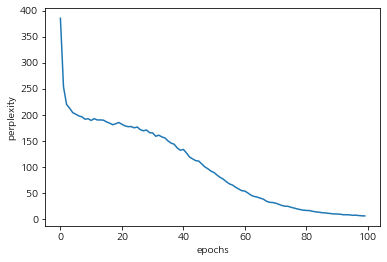

In [9]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

# RNNLM의 Trainer 클래스

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 419.19
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 385.30
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 265.95
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 222.54
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 210.74
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 208.71
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.67
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.63
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 194.88
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.24
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.00
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.04
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.26
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 186.45
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 185.58
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 189.62
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 188.34
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 182.94
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.51
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.62
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 176.80
| 에폭 22 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 175.

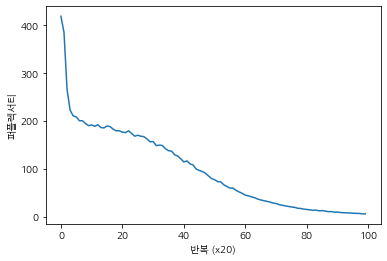

In [10]:
from common.trainer import RnnlmTrainer
from dataset import ptb


# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()